Call Center Simulation

220201003 Eray Gültekin

220201031 Eren Demir Özalban

220201057 Bahadır Türk

This Discrete Event Simulation models a call center using SimPy, featuring exponential arrivals and a callback mechanism for long queues. It logs every state change to calculate precise, time-weighted metrics like server utilization and average delay. These statistics are visualized using discrete step graphs ($Q(t)$ and $B(t)$) to analyze system performance and congestion.

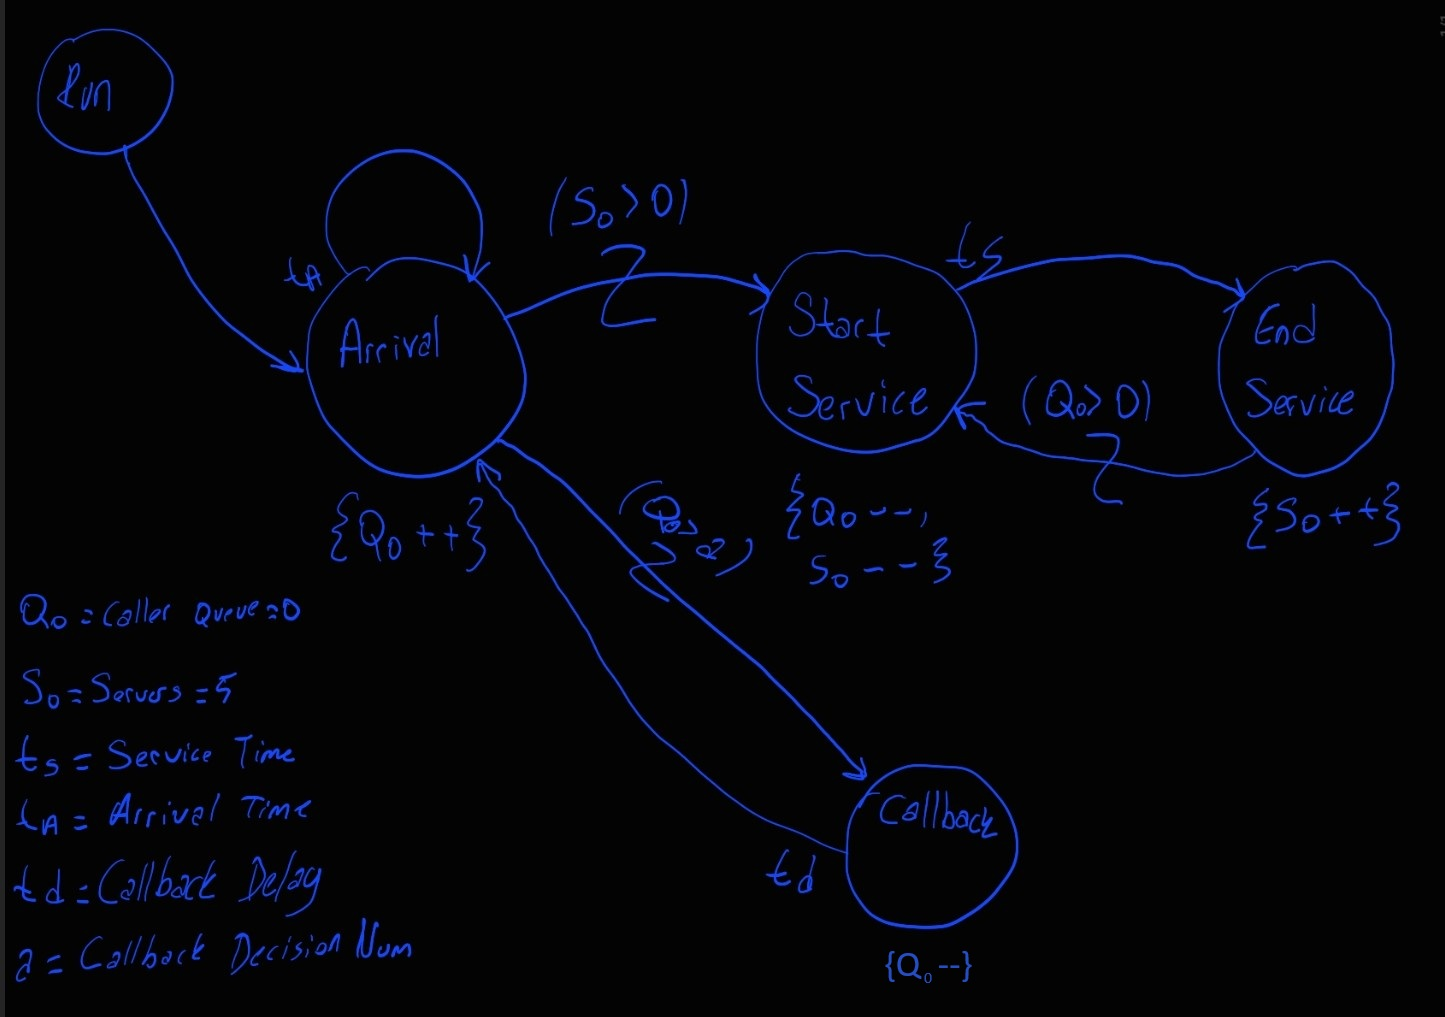

In [2]:
import simpy
import random
import pyray as pr
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

RAYLIB STATIC 5.5.0.4 LOADED


Configuration for simulation and single run down

In [5]:
#Simulation Parameters
AGENT_COUNT = 4 #4 6
CUSTOMER_WAIT_MEAN = 1.2
SERVICE_TIME = [5, 10]
CALLBACK_PROB = 0.3 
QUEUE_THRESHOLD = 3 #5
CALLBACK_DELAY = 10 


SIM_TIME = 300 # Total sim time for graphs
simulation_speed = 0.01 # Time speed for the animation

#To Change the simulation's randomness
random.seed(22)

Simulation Class

In [6]:
#Simulation Class
class CallCenterSim:
    def __init__(self, env, agent_count):
        self.env = env
        self.agents = simpy.Resource(env, agent_count)
        self.active_callbacks = 0
        self.data = []
        
        #LOGGING LISTS FOR GRAPHS
        #(time, value)
        self.log_queue_len = [(0, 0)]   # Q(t) data
        self.log_busy_agents = [(0, 0)] # B(t) data

    #Saving state for graphs
    def log_state(self):
        self.log_queue_len.append((self.env.now, len(self.agents.queue)))
        self.log_busy_agents.append((self.env.now, self.agents.count))

    def caller_arrival(self):
        i = 0
        while True:
            yield self.env.timeout(random.expovariate(1.0 / CUSTOMER_WAIT_MEAN))
            i += 1
            self.env.process(self.handle_call(f"Customer {i}"))

    def handle_call(self, name):
        arrival_time = self.env.now
        call_type = 'NORMAL'
        
        self.log_state()

        #Decision: Callback 
        if (len(self.agents.queue) > QUEUE_THRESHOLD) and (random.random() < CALLBACK_PROB):
            call_type = 'CALLBACK'
            self.log_state()
            self.env.process(self.handle_recall(name))
            return 
        
        #Join Queue
        with self.agents.request() as req:
            yield req 
            
            #Start Service
            call_start_time = self.env.now
            self.log_state()

            delay = call_start_time - arrival_time
            service_duration = random.uniform(SERVICE_TIME[0], SERVICE_TIME[1])
            
            yield self.env.timeout(service_duration)
            
            #End Service
            call_exit_time = self.env.now
            self.log_state()
            
            self.data.append({
                'id': name,
                'type': call_type,
                'wait_delay': delay,
                'total_system_time': call_exit_time - arrival_time,
                'duration': service_duration
            })

    def handle_recall(self, name):
        self.active_callbacks += 1
        yield self.env.timeout(CALLBACK_DELAY)
        self.active_callbacks -= 1
        self.env.process(self.handle_call(name))

Animation Functions

In [7]:
#Animation Functions
def draw_agents(sim, total_agents, start_x, start_y, size=100, gap=10):
    pr.draw_text("Agent Status:", start_x, start_y - 30, 20, pr.BLACK)

    for i in range(total_agents):
        if i < sim.agents.count:
            color = pr.RED
            status = "BUSY"
        else:
            color = pr.GREEN 
            status = "FREE"
        
        current_x = start_x + i * (size + gap)

        pr.draw_rectangle(current_x, start_y, size, size, color)
        pr.draw_rectangle_lines(current_x, start_y, size, size, pr.BLACK)
        pr.draw_text(f"Agent {i+1}\n{status}", current_x + 10, start_y + size // 2 - 20, 15, pr.BLACK)

def draw_queue(sim, start_x, start_y, radius =10, gap=5):
    count = len(sim.agents.queue)

    pr.draw_text("Queue:", start_x, start_y - 30, 20, pr.BLACK)
    for i in range(count):
        current_x = start_x + i * (2 * radius + gap)
        current_y = start_y
        pr.draw_circle(current_x + radius, current_y + radius, radius, pr.BLUE)
        pr.draw_circle_lines(current_x + radius, current_y + radius, radius, pr.BLACK)

def draw_callbacks(sim, start_x, start_y, radius=10, gap=5):
    count = sim.active_callbacks

    pr.draw_text("Active Callbacks:", start_x, start_y - 30, 20, pr.BLACK)
    for i in range(count):
        current_x = start_x + i * (2 * radius + gap)
        current_y = start_y
        pr.draw_circle(current_x + radius, current_y + radius, radius, pr.ORANGE)
        pr.draw_circle_lines(current_x + radius, current_y + radius, radius, pr.BLACK)

Animation Runner

In [8]:
#Main Animation Loop
def main():
    pr.init_window(800, 600, "Call Center Simulation")
    pr.set_target_fps(60)

    env = simpy.Environment()
    sim = CallCenterSim(env, AGENT_COUNT)
    env.process(sim.caller_arrival())
    while not pr.window_should_close():
        env.run(until=env.now + simulation_speed)

        pr.begin_drawing()
        pr.clear_background(pr.RAYWHITE)

        pr.draw_text(f"SimTime: {env.now:.2f}", 10, 10, 20, pr.BLACK)
        draw_agents(sim, AGENT_COUNT, 50, 100)

        draw_queue(sim,10,300,10,5)

        draw_callbacks(sim,10,450,10,5)

        pr.end_drawing()
    pr.close_window()

if __name__ == "__main__":
    main()

Single Sim Run

________________________________________
SIMULATION REPORT (T=300)
________________________________________
1. Avg Delay in Queue:      42.79 min
2. Service Level (<5min):   10.8%
3. Time-Avg Num in Queue:   42.06
4. Server Utilization:      99.67%
________________________________________


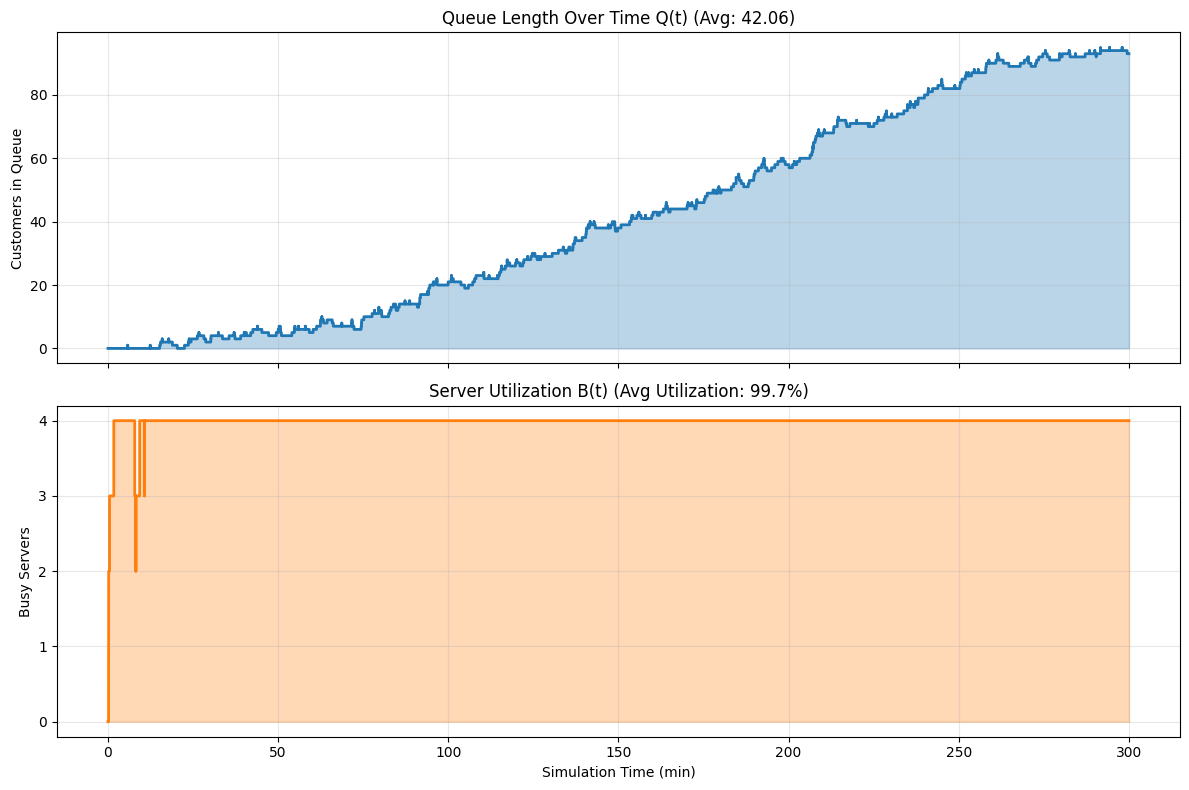

In [9]:
#RUN SIMULATION
env = simpy.Environment()
sim = CallCenterSim(env, AGENT_COUNT)
env.process(sim.caller_arrival())
env.run(until=SIM_TIME)

#CALCULATING METRICS
#Average Delay & Service Level (Wait < 5 min)
delays = [d['wait_delay'] for d in sim.data]
avg_delay = np.mean(delays)

# Count how many were served in under 5 minutes (Service Level)
served_within_5 = sum(1 for d in delays if d < 5)
percent_within_5 = (served_within_5 / len(delays)) * 100

#Time-Weighted Averages
def get_time_weighted_avg(log_list, total_time):
    total_area = 0
    # Add end point to close the graph
    log_list.append((total_time, log_list[-1][1])) 
    
    for i in range(len(log_list) - 1):
        t_now, val = log_list[i]
        t_next, _ = log_list[i+1]
        duration = t_next - t_now
        total_area += val * duration
    return total_area / total_time

avg_num_in_queue = get_time_weighted_avg(sim.log_queue_len, SIM_TIME)
avg_busy_servers = get_time_weighted_avg(sim.log_busy_agents, SIM_TIME)
server_utilization = avg_busy_servers / AGENT_COUNT

#PRINT REPORT
print("_"*40)
print(f"SIMULATION REPORT (T={SIM_TIME})")
print("_"*40)
print(f"1. Avg Delay in Queue:      {avg_delay:.2f} min")
print(f"2. Service Level (<5min):   {percent_within_5:.1f}%")
print(f"3. Time-Avg Num in Queue:   {avg_num_in_queue:.2f}")
print(f"4. Server Utilization:      {server_utilization:.2%}")
print("_"*40)


#PLOT GRAPHS
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Graph 1: Q(t) - Queue Length
q_times, q_values = zip(*sim.log_queue_len)
ax1.step(q_times, q_values, where='post', color='tab:blue', linewidth=2)
ax1.fill_between(q_times, q_values, step='post', alpha=0.3, color='tab:blue')
ax1.set_title(f"Queue Length Over Time Q(t) (Avg: {avg_num_in_queue:.2f})")
ax1.set_ylabel("Customers in Queue")
ax1.grid(True, alpha=0.3)

# Graph 2: B(t) - Server Busy Status
b_times, b_values = zip(*sim.log_busy_agents)
ax2.step(b_times, b_values, where='post', color='tab:orange', linewidth=2)
ax2.fill_between(b_times, b_values, step='post', alpha=0.3, color='tab:orange')
ax2.set_title(f"Server Utilization B(t) (Avg Utilization: {server_utilization:.1%})")
ax2.set_ylabel("Busy Servers")
ax2.set_xlabel("Simulation Time (min)")
ax2.set_yticks(range(AGENT_COUNT + 1)) # Force integer ticks 0-5
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Configuration for Experiments

--- RUNNING STATISTICAL ANALYSIS (1095 replications) ---
Average Delay: 47.54 min
Standard Deviation: 8.43
95% Confidence Interval: [47.04, 48.04]

--- REQUIRED REPLICATIONS CHECK ---
Target Error Margin: +/- 0.5 min
Optimal Replications Needed: 1096
>> WARNING: You need 1 more runs.

--- FACTOR ANALYSIS: AGENTS [4,5,6] & QUEUE LIMITS [3,5] ---

Testing Queue Limit: 3
   Agents: 4 -> Avg Delay: 47.89 min
   Agents: 5 -> Avg Delay: 31.25 min
   Agents: 6 -> Avg Delay: 9.51 min

Testing Queue Limit: 5
   Agents: 4 -> Avg Delay: 44.21 min
   Agents: 5 -> Avg Delay: 29.51 min
   Agents: 6 -> Avg Delay: 12.85 min


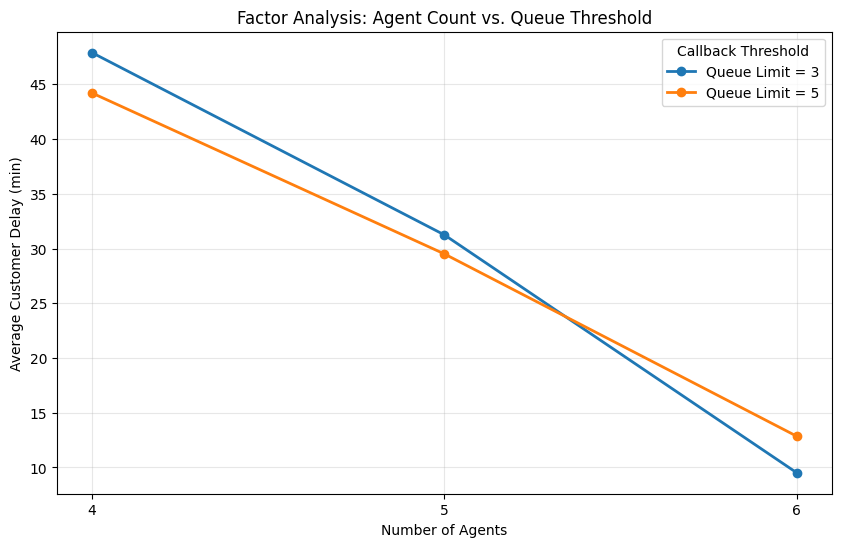

In [19]:
# --- CONFIGURATION FOR EXPERIMENTS ---
NUM_REPLICATIONS = 1095     # Initial number of runs for statistical analysis
CONFIDENCE_LEVEL = 0.95   # 95% Confidence
DESIRED_ERROR = 0.5       # Acceptable error margin (minutes)

# --- 1. HELPER FUNCTION TO RUN ONE SIMULATION ---
def run_single_replication(seed, agent_c):
    """Runs the simulation once and returns the Average Delay."""
    random.seed(seed)
    env = simpy.Environment()
    # Note: This uses the global QUEUE_THRESHOLD variable found in your class logic
    sim = CallCenterSim(env, agent_c)
    env.process(sim.caller_arrival())
    env.run(until=SIM_TIME)
    
    # Calculate Avg Delay from data collected
    if sim.data:
        delays = [d['wait_delay'] for d in sim.data]
        return np.mean(delays)
    return 0.0

# ==============================================================================
# PART 2: STATISTICAL ANALYSIS (Requirements 1 & 2)
# ==============================================================================
print(f"--- RUNNING STATISTICAL ANALYSIS ({NUM_REPLICATIONS} replications) ---")
replication_results = []

# Use the default AGENT_COUNT for this baseline analysis
for i in range(NUM_REPLICATIONS):
    res = run_single_replication(seed=i*123, agent_c=AGENT_COUNT) 
    replication_results.append(res)

# Calculate Statistics
mean_delay = np.mean(replication_results)
std_dev = np.std(replication_results, ddof=1)
std_error = std_dev / math.sqrt(NUM_REPLICATIONS)

# Calculate Confidence Interval
t_critical = stats.t.ppf((1 + CONFIDENCE_LEVEL) / 2, df=NUM_REPLICATIONS - 1)
margin_of_error = t_critical * std_error
ci_lower = mean_delay - margin_of_error
ci_upper = mean_delay + margin_of_error

print(f"Average Delay: {mean_delay:.2f} min")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"{int(CONFIDENCE_LEVEL*100)}% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

# Identify Best Number of Replications
optimal_replications = math.ceil(( (t_critical * std_dev) / DESIRED_ERROR ) ** 2)
print("\n--- REQUIRED REPLICATIONS CHECK ---")
print(f"Target Error Margin: +/- {DESIRED_ERROR} min")
print(f"Optimal Replications Needed: {optimal_replications}")

if NUM_REPLICATIONS >= optimal_replications:
    print(">> Current number of replications is sufficient.")
else:
    print(f">> WARNING: You need {optimal_replications - NUM_REPLICATIONS} more runs.")

# ==============================================================================
# PART 3: FACTOR ANALYSIS (Requirement 3)
# Varying Agents (4, 5, 6) and Queue Thresholds (3, 5)
# ==============================================================================
print("\n" + "="*50)
print("--- FACTOR ANALYSIS: AGENTS [4,5,6] & QUEUE LIMITS [3,5] ---")
print("="*50)

agent_factors = [4, 5, 6]
queue_factors = [3, 5]
REPS_PER_FACTOR = 10  # Smaller batch for factors to save time

# Dictionary to store results: { queue_limit: [avg_delay_agent4, avg_delay_agent5...] }
factor_results = {q: [] for q in queue_factors}

# Loop through Queue Thresholds first
for q_thresh in queue_factors:
    # UPDATE GLOBAL VARIABLE FOR THIS BATCH
    global QUEUE_THRESHOLD
    QUEUE_THRESHOLD = q_thresh
    
    print(f"\nTesting Queue Limit: {q_thresh}")
    
    # Loop through Agent Counts
    for agent_c in agent_factors:
        batch_delays = []
        for i in range(REPS_PER_FACTOR):
            # Unique seed for every run to ensure randomness
            seed_val = (i * 1000) + (agent_c * 100) + q_thresh
            batch_delays.append(run_single_replication(seed=seed_val, agent_c=agent_c))
        
        avg_factor_delay = np.mean(batch_delays)
        factor_results[q_thresh].append(avg_factor_delay)
        print(f"   Agents: {agent_c} -> Avg Delay: {avg_factor_delay:.2f} min")

# --- PLOTTING ---
plt.figure(figsize=(10, 6))

for q_thresh, delays in factor_results.items():
    plt.plot(agent_factors, delays, marker='o', linewidth=2, label=f'Queue Limit = {q_thresh}')

plt.title("Factor Analysis: Agent Count vs. Queue Threshold")
plt.xlabel("Number of Agents")
plt.ylabel("Average Customer Delay (min)")
plt.xticks(agent_factors)
plt.legend(title="Callback Threshold")
plt.grid(True, alpha=0.3)
plt.show()

# Reset Queue Threshold to default just in case
QUEUE_THRESHOLD = 3